<a href="https://colab.research.google.com/github/jumafernandez/imbalanced_data/blob/main/notebooks/estrategia_propia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recuperación de instancias no sintéticas

__Autor:__ Juan Manuel Fernandez

__Objetivo:__ En esta notebook se evalúa una estrategia de balanceo de instancias propia basada en la recuperación de instancias no sintéticas como estrategia para el balanceo de clases para problemas de clasificación automática de textos.

## Instalación y Carga de librerías y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=d354830c36d9fabace6ce380f6b244cf0fdfe19534012cc626aa753f5e3f9cdd
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 4.6 MB/s 
     |████████████████████████████████| 199 kB 35.8 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/semi-supervisado/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/supervisado/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

Y las utilizadas para la representación de documentos.

In [4]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/supervisado/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import representacion_documentos

### Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [5]:
import warnings
from os import path
import pandas as pd
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/data/'
TRAIN_FILE = '02-01-correos-train-80.csv'
TEST_FILE = '02-02-correos-test-20.csv'

etiquetas = get_clases()

# Chequeo sobre si los archivos están en el working directory
if not(path.exists(TRAIN_FILE)):
  # Genero el enlace completo
  URL_file_train = DS_DIR + TRAIN_FILE
  URL_file_test = DS_DIR + TEST_FILE
  # Descargo los archivos
  import wget
  wget.download(URL_file_train)
  wget.download(URL_file_test)
  
# Leemos el archivo en un dataframe
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
df_train['consulta'] = list(preprocesar_correos(df_train['consulta']))
df_test['consulta'] = list(preprocesar_correos(df_test['consulta']))

print(f"\nEl conjunto de entrenamiento tiene la dimensión: {len(df_train)}.")
print(f"El conjunto de testeo tiene la dimensión: {len(df_test)}.")

df_train = df_train[['consulta', 'clase']]

consultas_test = list(df_test['consulta'])
y_test = list(df_test['clase'])


El conjunto de entrenamiento tiene la dimensión: 800.
El conjunto de testeo tiene la dimensión: 200.


### Incorporación de las instancias no sintéticas para el balanceo de carga

Se incorporan las instancias no sintéticas recuperadas de Elasticsearch para las estrategias de *feature selection* (SS3  $U$ TF-IDF).

En primer lugar se carga el dataset con 200 instancias por clase recuperadas con boosting:

In [6]:
DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/data/03-elasticsearch/sin_procesar/'

FILE_ss3 = 'dataset-ss3-200-boosting.csv'
FILE_tfidf = 'dataset-tfidf-200-boosting.csv'

if not(path.exists(FILE_ss3)) or not(path.exists(FILE_tfidf)):
  # Genero el enlace completo
  URL_file_ss3 = DIR + FILE_ss3
  URL_file_tfidf = DIR + FILE_tfidf
  # Descargo los archivos
  import wget
  wget.download(URL_file_ss3)
  wget.download(URL_file_tfidf)

# Leemos los archivos en un dataframe
df_ss3 = pd.read_csv(FILE_ss3)
df_tfidf = pd.read_csv(FILE_tfidf)

df_ss3 = df_ss3[['consulta', 'score', 'clase']]
df_tfidf = df_tfidf[['consulta', 'score', 'clase']]

# Preprocesamos las consultas
df_ss3['consulta'] = pd.Series(preprocesar_correos(df_ss3['consulta']))
df_tfidf['consulta'] = pd.Series(preprocesar_correos(df_tfidf['consulta']))

# Verifico que no haya instancias con faltantes y si hay las borro
df_ss3 = df_ss3.dropna()
df_tfidf = df_tfidf.dropna()

print(f"\nEl conjunto de datos SS3 posee {len(df_ss3)} instancias.")
print(f"El conjunto de datos TF-IDF posee {len(df_tfidf)} instancias.")


El conjunto de datos SS3 posee 3200 instancias.
El conjunto de datos TF-IDF posee 3200 instancias.


Ahora joineamos las instancias de cada estrategia que coinciden y hacemos el promedio de los scores para cada estrategia:

In [7]:
# Transformo un df a una lista de diccionarios
ss3_list = df_ss3.to_dict('records')

# Y el otro en 3 listas (una con la consulta, otra con el score y otra con la clase)
tf_consulta = list(df_tfidf['consulta'])
tf_clase = list(df_tfidf['clase'])
tf_score = list(df_tfidf['score'])

In [8]:
join_consultas = pd.DataFrame(columns = ['consulta', 'score', 'clase'])
                    
for r in ss3_list:
  if (r['consulta'] in tf_consulta) and (r['clase'] == tf_clase[tf_consulta.index(r['consulta'])]):
    
    # Me guardo un df con la consulta y el score promedio
    score_avg = (r['score'] + tf_score[tf_consulta.index(r['consulta'])])/2
    aux = {'consulta': r['consulta'], 'score': score_avg, 'clase': r['clase']}
        
    join_consultas = join_consultas.append(aux, ignore_index=True)

Obtenemos la siguiente cantidad de instancias no sintéticas por clase:

In [9]:
cantidad_balanceo = join_consultas.groupby(['clase'])['clase'].count()

cantidad_balanceo

clase
Boleto Universitario                    74
Cambio de Carrera                       68
Cambio de Comisión                      95
Consulta por Equivalencias              38
Consulta por Legajo                     84
Consulta sobre Título Universitario     68
Cursadas                                28
Datos Personales                        54
Exámenes                                82
Ingreso a la Universidad                71
Pedido de Certificados                 137
Problemas con la Clave                 124
Reincorporación                         21
Requisitos de Ingreso                  147
Simultaneidad de Carreras               70
Situación Académica                     47
Name: clase, dtype: int64

Ordeno las instancias no sintéticas por clase y score (descendente):

In [10]:
join_consultas = join_consultas.sort_values(['clase','score'], ascending=False)

join_consultas

,consulta,score,clase
1162,buenos dias comunico situacion academica respe...,26.721049,Situación Académica
1163,buenas tardes curse gimnasia formativa 34004 p...,25.319655,Situación Académica
1161,buenos dias duda respecto situacion academica ...,24.868055,Situación Académica
1164,hola 16 mayo rendi final taller lectura compre...,22.607658,Situación Académica
1190,buenos dias quisiera saber figura finales cond...,22.222622,Situación Académica
...,...,...,...
67,buenas tardes quisiera realizar consulta respe...,22.612747,Boleto Universitario
73,buenos dias cuatrimestre pasado inscribi bolet...,22.587778,Boleto Universitario
70,buen dia boleto estudiantil hace varios meses ...,22.451445,Boleto Universitario
63,hice tramite boleto estudiantil hace meses tod...,22.184043,Boleto Universitario


#### Incorporación al conjunto de datos original de las instancias no sintéticas

En primer lugar, evalúo la cantidad de instancias por clase que tengo en el dataset de entrenamiento:

In [11]:
instancias_por_clase = df_train.groupby(['clase'])['clase'].count()

max_instancias = df_train.groupby(['clase'])['clase'].count().max()

instancias_por_clase

clase
Boleto Universitario                   193
Cambio de Carrera                       11
Cambio de Comisión                       8
Consulta por Equivalencias              10
Consulta por Legajo                     15
Consulta sobre Título Universitario     10
Cursadas                                75
Datos Personales                         6
Exámenes                                18
Ingreso a la Universidad               135
Pedido de Certificados                  59
Problemas con la Clave                  91
Reincorporación                         43
Requisitos de Ingreso                   98
Simultaneidad de Carreras                6
Situación Académica                     22
Name: clase, dtype: int64

In [12]:
X_train = []
y_train = []

for clase in etiquetas:
  # Calculo la cantidad de instancias a agregar según la necesidad y disponibilidad
  cantidad = min(max_instancias - instancias_por_clase[clase], cantidad_balanceo[clase])
  # Las selecciono
  instancias_clase = join_consultas.loc[join_consultas['clase'] == clase][['consulta', 'clase']].head(cantidad)

  # Las agrego
  df_train = df_train.append(instancias_clase, ignore_index=True)
  print(f'{clase}: {cantidad}')

Boleto Universitario: 0
Cambio de Carrera: 68
Cambio de Comisión: 95
Consulta por Equivalencias: 38
Consulta por Legajo: 84
Consulta sobre Título Universitario: 68
Cursadas: 28
Datos Personales: 54
Exámenes: 82
Ingreso a la Universidad: 58
Pedido de Certificados: 134
Problemas con la Clave: 102
Reincorporación: 21
Requisitos de Ingreso: 95
Simultaneidad de Carreras: 70
Situación Académica: 47


Verifico la cantidad de instancias finales por clase:

In [13]:
df_train.groupby(['clase'])['clase'].count()

clase
Boleto Universitario                   193
Cambio de Carrera                       79
Cambio de Comisión                     103
Consulta por Equivalencias              48
Consulta por Legajo                     99
Consulta sobre Título Universitario     78
Cursadas                               103
Datos Personales                        60
Exámenes                               100
Ingreso a la Universidad               193
Pedido de Certificados                 193
Problemas con la Clave                 193
Reincorporación                         64
Requisitos de Ingreso                  193
Simultaneidad de Carreras               76
Situación Académica                     69
Name: clase, dtype: int64

Separo en train y test:

In [14]:
consultas_train = list(df_train['consulta'])
y_train = list(df_train['clase'])

### Estrategia de representación de la consulta

A continuación se representa la consulta a partir de features.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3,4), token_pattern = '[\w\/\%]+')

X_train = vectorizer.fit_transform(consultas_train)
X_test = vectorizer.transform(consultas_test)     

# Esta función va dentro de un iterador entre las 5 estrategias   
estrategia = '3-4-NGRAM-CHARS' 
print('Estrategia de representación: {}' . format(estrategia))

Estrategia de representación: 3-4-NGRAM-CHARS


## Generación de Modelos

Se generan modelos en función de los datos balanceados con la estrategia propuesta.

Se define el espacio de búsqueda para el ajuste de hiperparámetros de todos los modelos:

In [16]:
BUSCA_MEJOR_MODELO = True

if BUSCA_MEJOR_MODELO:
  # Defino los parámetros para GridSearchCV
  params_svm = {'C': [0.01, 0.1, 1], 
                'gamma': [0.1, 0.01],
                'class_weight': [None, 'balanced'],
                'kernel': ['rbf', 'linear', 'sigmoid']
                }

Se importan las librerías a utilizar:

In [17]:
import time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Vemos un reporte de clasificación de varias métricas
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score


Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [18]:
# Calculo la hora actual
hora_actual = time.strftime('%H:%M:%S', time.localtime())

grid_search=GridSearchCV(SVC(), param_grid=params_svm, cv=None, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Se realizan las predicciones sobre el conjunto de validación
predictions = grid_search.predict(X_test) 

# Modelo a "mano"
#clf = SVC(C=0.1, class_weight='balanced', gamma=0.01, kernel='linear')
#clf.fit(X_resampled, y_resampled)
#clf.fit(X_train, y_train)
# Genero las clases para los casos de prueba, según el modelo
#predictions = clf.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [19]:
print(classification_report_imbalanced(y_test, predictions, target_names=etiquetas))
print(f'Accuracy: {accuracy_score(y_test, predictions)}')

                                           pre       rec       spe        f1       geo       iba       sup

               Boleto Universitario       1.00      0.98      1.00      0.99      0.99      0.98        48
                  Cambio de Carrera       0.67      1.00      0.99      0.80      1.00      1.00         2
                 Cambio de Comisión       1.00      1.00      1.00      1.00      1.00      1.00         2
         Consulta por Equivalencias       1.00      0.67      1.00      0.80      0.82      0.64         3
                Consulta por Legajo       0.40      0.67      0.98      0.50      0.81      0.64         3
Consulta sobre Título Universitario       0.75      1.00      0.99      0.86      1.00      1.00         3
                           Cursadas       0.53      0.89      0.92      0.67      0.91      0.82        19
                   Datos Personales       0.00      0.00      0.99      0.00      0.00      0.00         2
                           Exámenes 

## Matriz de confusión

Se genera una matriz de confusión de uno de los modelos.

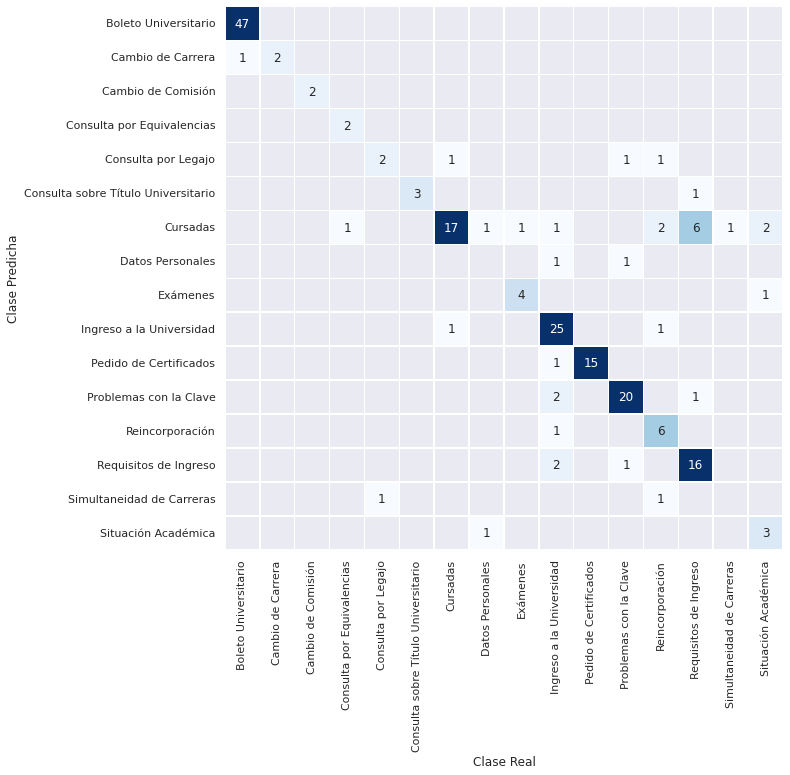

In [20]:
def matriz_confusion(y_real, y_predictions):
  """
  Grafica una matriz de confusión con seaborn en función de la clase observada
  y la clase predicha.
  """

  import numpy as np
  from sklearn import metrics
  import seaborn as sns
  import matplotlib.pyplot as plt
  
  matriz_confusion = metrics.confusion_matrix(y_real, y_predictions).T
  etiquetas = np.unique(y_real)

  sns.set()
  my_mask = np.zeros((matriz_confusion.shape[0], matriz_confusion.shape[0]), dtype=int)
  for i in range(matriz_confusion.shape[0]):
      for j in range(matriz_confusion.shape[0]):
          my_mask[i][j] = matriz_confusion[i][j] == 0 
    
  fig_dims = (10, 10)
  plt.subplots(figsize=fig_dims)

  ax = sns.heatmap(matriz_confusion,
                  xticklabels=etiquetas,
                  annot=True, 
                  fmt="d", 
                  linewidths=.5, 
                  cmap="Blues", 
                  cbar=False, 
                  mask=my_mask, 
                  vmax=15)

  plt.gcf().set_size_inches(10, 10)
  plt.xticks(rotation=90, ha="center")
  plt.yticks(np.arange(len(etiquetas))+0.5, etiquetas, rotation='horizontal')

  plt.xlabel('Clase Real')
  plt.ylabel('Clase Predicha');

  plt.show()

matriz_confusion(y_test, predictions)

# Referencias
- imbalanced-learn documentation https://imbalanced-learn.org/
- sklearn.model_selection.GridSearchCV https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- ML Pipelines using scikit-learn and GridSearchCV https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05